# Forward Rendering

This notebook demonstrates how to solve the radiative transfer using SHDOM and render an image.

The source Fortran code was created by Frank Evans and it is part of the SHDOM package: http://nit.colorado.edu/shdom.html

The python wrapper was created by Aviad Levis and Amit Aides, Technion Inst. of Technology 2019: https://github.com/aviadlevis/pyshdom

In [1]:
"""
Imports necessary for this notebook
"""
import os 
import matplotlib.pyplot as plt
import numpy as np

import shdom

In [3]:
""" 
Mie object loads a previously saved mie table.

Rayleigh object initilizes Rayleigh scattering according to a temperature profile.
Temperature profile here is of summer mid-latitude for 0-20km taken from AFGL  
"""

# Mie scattering for water droplets
mie = shdom.Mie()
mie.read_table(file_path='../mie_tables/Water_672nm.scat')

# Rayleigh scattering for air molecules
temperatures = [292.220, 292.040, 291.860, 291.680, 291.500, 291.320, 291.140, 290.960, 290.780, 
                290.600, 290.420, 290.240, 290.060, 289.880, 289.700, 289.920, 290.140, 290.360, 
                290.580, 290.800, 291.020, 291.240, 291.460, 291.680, 291.900]
z_levels = np.linspace(0.0, 20.0, len(temperatures))
temperature_profile = shdom.TemperatureProfile(z_levels, temperatures)
rayleigh = shdom.Rayleigh(wavelength=0.672, temperature_profile=temperature_profile)

Reading mie table from file: ../mie_tables/Water_672nm.scat
Done.


In [4]:
""" 
Load a Large-Eddy-Simulated cloud from a csv file.
Using the mie tables (loaded in the previous cell) the liquid water content and 
effective radii are transformed into the extinction and phase function on a 3D grid.
The lwc/phase are used to initilize a Medium object.
"""
csv_path = '../synthetic_cloud_fields/jpl_les/32x36x25.txt'

lwc, reff = shdom.load_les_from_csv(csv_path)
extinction_c, albedo_c, phase_c = mie.interpolate_scattering_field(lwc, reff)
droplets = shdom.Medium(extinction_c, albedo_c, phase_c)

extinction_a, albedo_a, phase_a = rayleigh.get_scattering_field(z_levels=droplets.grid.z_levels)
air = shdom.Medium(extinction_a, albedo_a, phase_a)

atmosphere = droplets + air

<IPython.core.display.Javascript object>


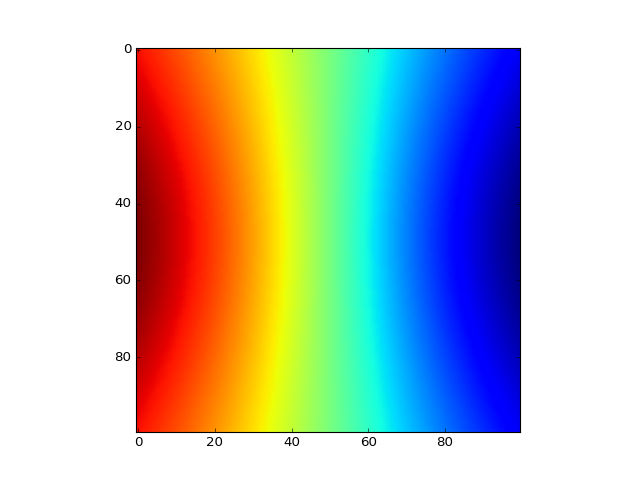

In [17]:
plt.figure()
plt.imshow(sensor.phi.reshape(sensor.resolution))

In [8]:
mu, phi

(array([-0.57735026, -0.57735026, -0.57735026, -0.57735026], dtype=float32),
 array([ 0.78539819,  5.497787  ,  2.3561945 ,  3.92699075], dtype=float32))

<IPython.core.display.Javascript object>


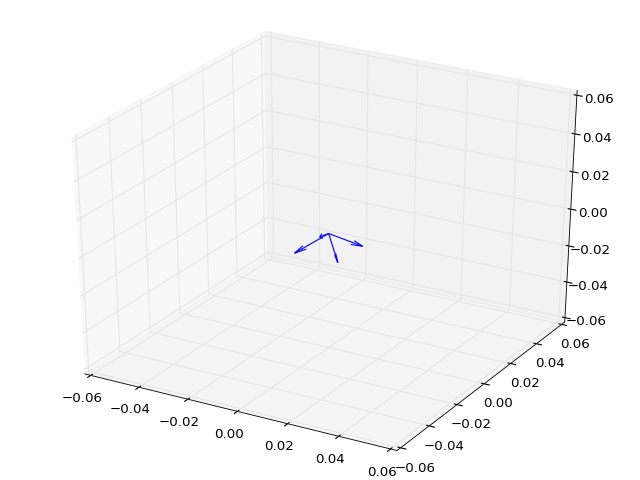

In [7]:
from mpl_toolkits.mplot3d import axes3d, Axes3D 
mu = sensor.mu.reshape(sensor.resolution)[[0, -1, 0, -1],[0, 0, -1, -1]]
phi = sensor.phi.reshape(sensor.resolution)[[0, -1, 0, -1],[0, 0, -1, -1]]

u = np.sqrt(1 - mu**2) * np.cos(phi)
v = np.sqrt(1 - mu**2) * np.sin(phi)
w = mu
x = np.full(4, sensor.position[0], dtype=np.float32)
y = np.full(4, sensor.position[1], dtype=np.float32)
z = np.full(4, sensor.position[2], dtype=np.float32)

%matplotlib notebook
fig = plt.figure()
ax = Axes3D(fig)
ax.quiver(x, y, z, u, v, w, length=0.015, pivot='tail')
plt.show()

In [2]:
sensor = shdom.ProjectiveSensor(fov=45, nx=100, ny=100, x=0.0, y=0.0, z=0.0)

sensor.look_at_transform(point=[1.0, 1.0, 1.0], up=[0,0,1])

plt.figure()
sensor.plot()

In [15]:
"""
Initilize an RteSolver object and attach the Medium to it. 
This will initialize all of shdom internal structures and grids.

SceneParameters() contains parameters such as surface albedo and solar radiance
NumericalParameters() contains parameters such as number of angular bins and split cell ratio.
All parameters have default values.
"""
scene_params = shdom.SceneParameters()
numerical_params = shdom.NumericalParameters()

numerical_params.deltam = True
scene_params.source.zenith = 180

rte_solver = shdom.RteSolver(scene_params, numerical_params)
rte_solver.init_medium(atmosphere)

In [16]:
"""
TODO
"""
rte_solver.solve(maxiter=100)

In [17]:
"""
TODO
"""
sensor = shdom.OrthographicSensor(bounding_box=atmosphere.bounding_box, 
                                  x_resolution=0.02, 
                                  y_resolution=0.02, 
                                  azimuth=0.0, 
                                  zenith=0.0,
                                  altitude='TOA')

image = sensor.render(rte_solver)

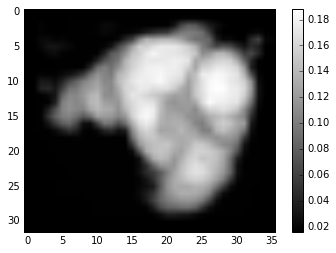

In [18]:
%matplotlib inline
plt.imshow(image)
plt.gray()
plt.colorbar()